In [6]:
import thoi
from thoi.measures.gaussian_copula import multi_order_measures, nplets_measures
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


Using device: cuda


In [23]:
out = np.load('mods_new_32.npy', allow_pickle=True).item()
out.keys()

model_dirs = ['laconeu_contextdm1_contextdm2_32',
              'laconeu_delaydm1_dm1_32',
              'laconeu_dm1_contextdm1_32',
              'laconeu_dmcgo_dmcnogo_32',
              'laconeu_fdanti_dm1_32']

In [34]:
alldata = {}
for model in model_dirs:
    modelh = {}
    for task in out[model].keys():
        #print(f'{model}_{task}')
        hlist = []
        for i in range(4):
            hmat = out[model][task]['h'][i]
            hjoinmatrix = np.swapaxes(hmat[:,:,:],0,1).reshape(-1,hmat.shape[-1]).T
            hlist.append(hjoinmatrix)
        allh = np.concatenate(hlist, axis=1)
        #print(task, allh.shape)
        modelh[task] = allh
    alldata[model] = modelh
shorterlength = min([alldata[model][task].shape[1] for model in model_dirs for task in alldata[model].keys()])


16000

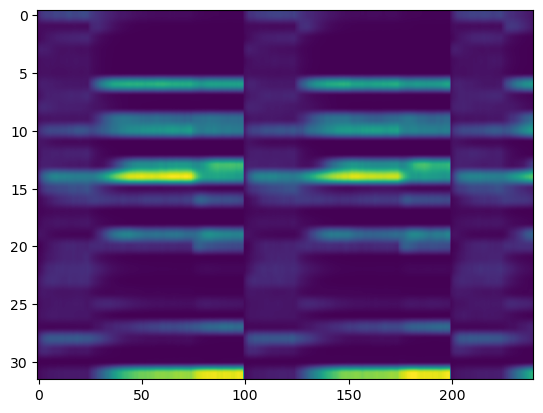

In [36]:
plt.imshow(alldata['laconeu_contextdm1_contextdm2_32']['contextdm1'].T, aspect='auto')

In [63]:
all_meanhoi = []

for model in model_dirs:
    for task in alldata[model].keys():
        print(model, task, alldata[model][task].shape)
        htensor = torch.tensor(alldata[model][task].T, dtype=torch.float32, device='cuda')
        hoidata = multi_order_measures(alldata[model][task][:,:shorterlength].T, min_order=1, max_order=6)
        meanhoi = hoidata.groupby('order').mean()[["o", "s", "tc", "dtc"]]
        # Add model and task columns
        meanhoi['model'] = model
        meanhoi['task'] = task
        all_meanhoi.append(meanhoi)

# Concatenate all meanhoi dataframes
concatenated_meanhoi = pd.concat(all_meanhoi)
#save the concat dataframe
concatenated_meanhoi = concatenated_meanhoi.reset_index()
concatenated_meanhoi.to_csv('concatenated_meanhoi_trimmed.csv')


laconeu_contextdm1_contextdm2_32 contextdm1 (32, 200000)


Order:   0%|          | 0/6 [00:00<?, ?it/s]

laconeu_contextdm1_contextdm2_32 contextdm2 (32, 200000)


laconeu_contextdm1_contextdm2_32 random (32, 256000)


laconeu_delaydm1_dm1_32 delaydm1 (32, 60000)


laconeu_delaydm1_dm1_32 dm1 (32, 50000)


laconeu_delaydm1_dm1_32 random (32, 256000)


laconeu_dm1_contextdm1_32 dm1 (32, 50000)


laconeu_dm1_contextdm1_32 contextdm1 (32, 200000)


laconeu_dm1_contextdm1_32 random (32, 256000)


laconeu_dmcgo_dmcnogo_32 dmcgo (32, 43200)


laconeu_dmcgo_dmcnogo_32 dmcnogo (32, 43200)


laconeu_dmcgo_dmcnogo_32 random (32, 256000)


laconeu_fdanti_dm1_32 fdanti (32, 16000)


laconeu_fdanti_dm1_32 dm1 (32, 50000)


laconeu_fdanti_dm1_32 random (32, 256000)


In [74]:
concatenated_meanhoi = concatenated_meanhoi.reset_index()


<Axes: xlabel='order', ylabel='o'>

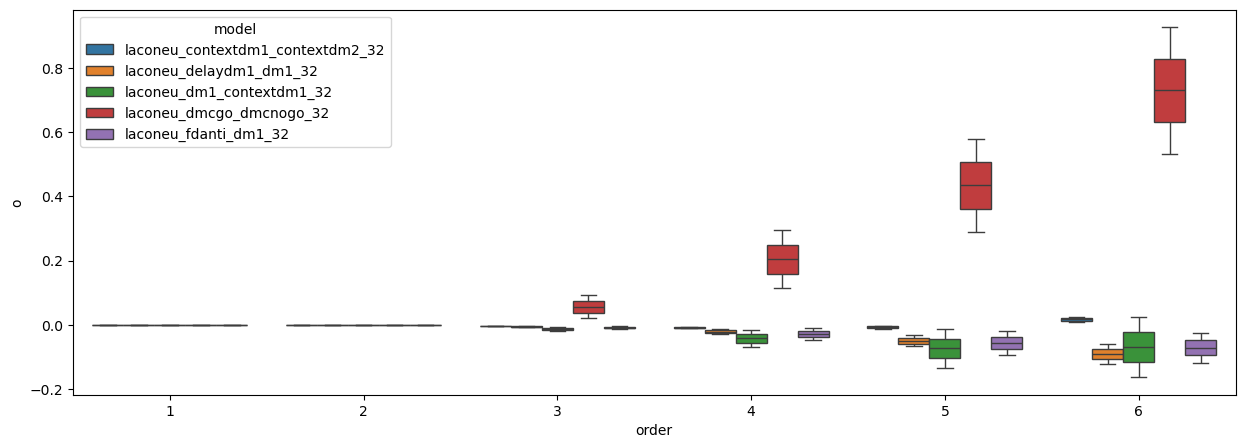

In [71]:
#concatenated_meanhoi
plt.figure(figsize=(15, 5))
sns.boxplot(data=concatenated_meanhoi[concatenated_meanhoi['task'] != 'random'], x='order', y='o', hue='model')


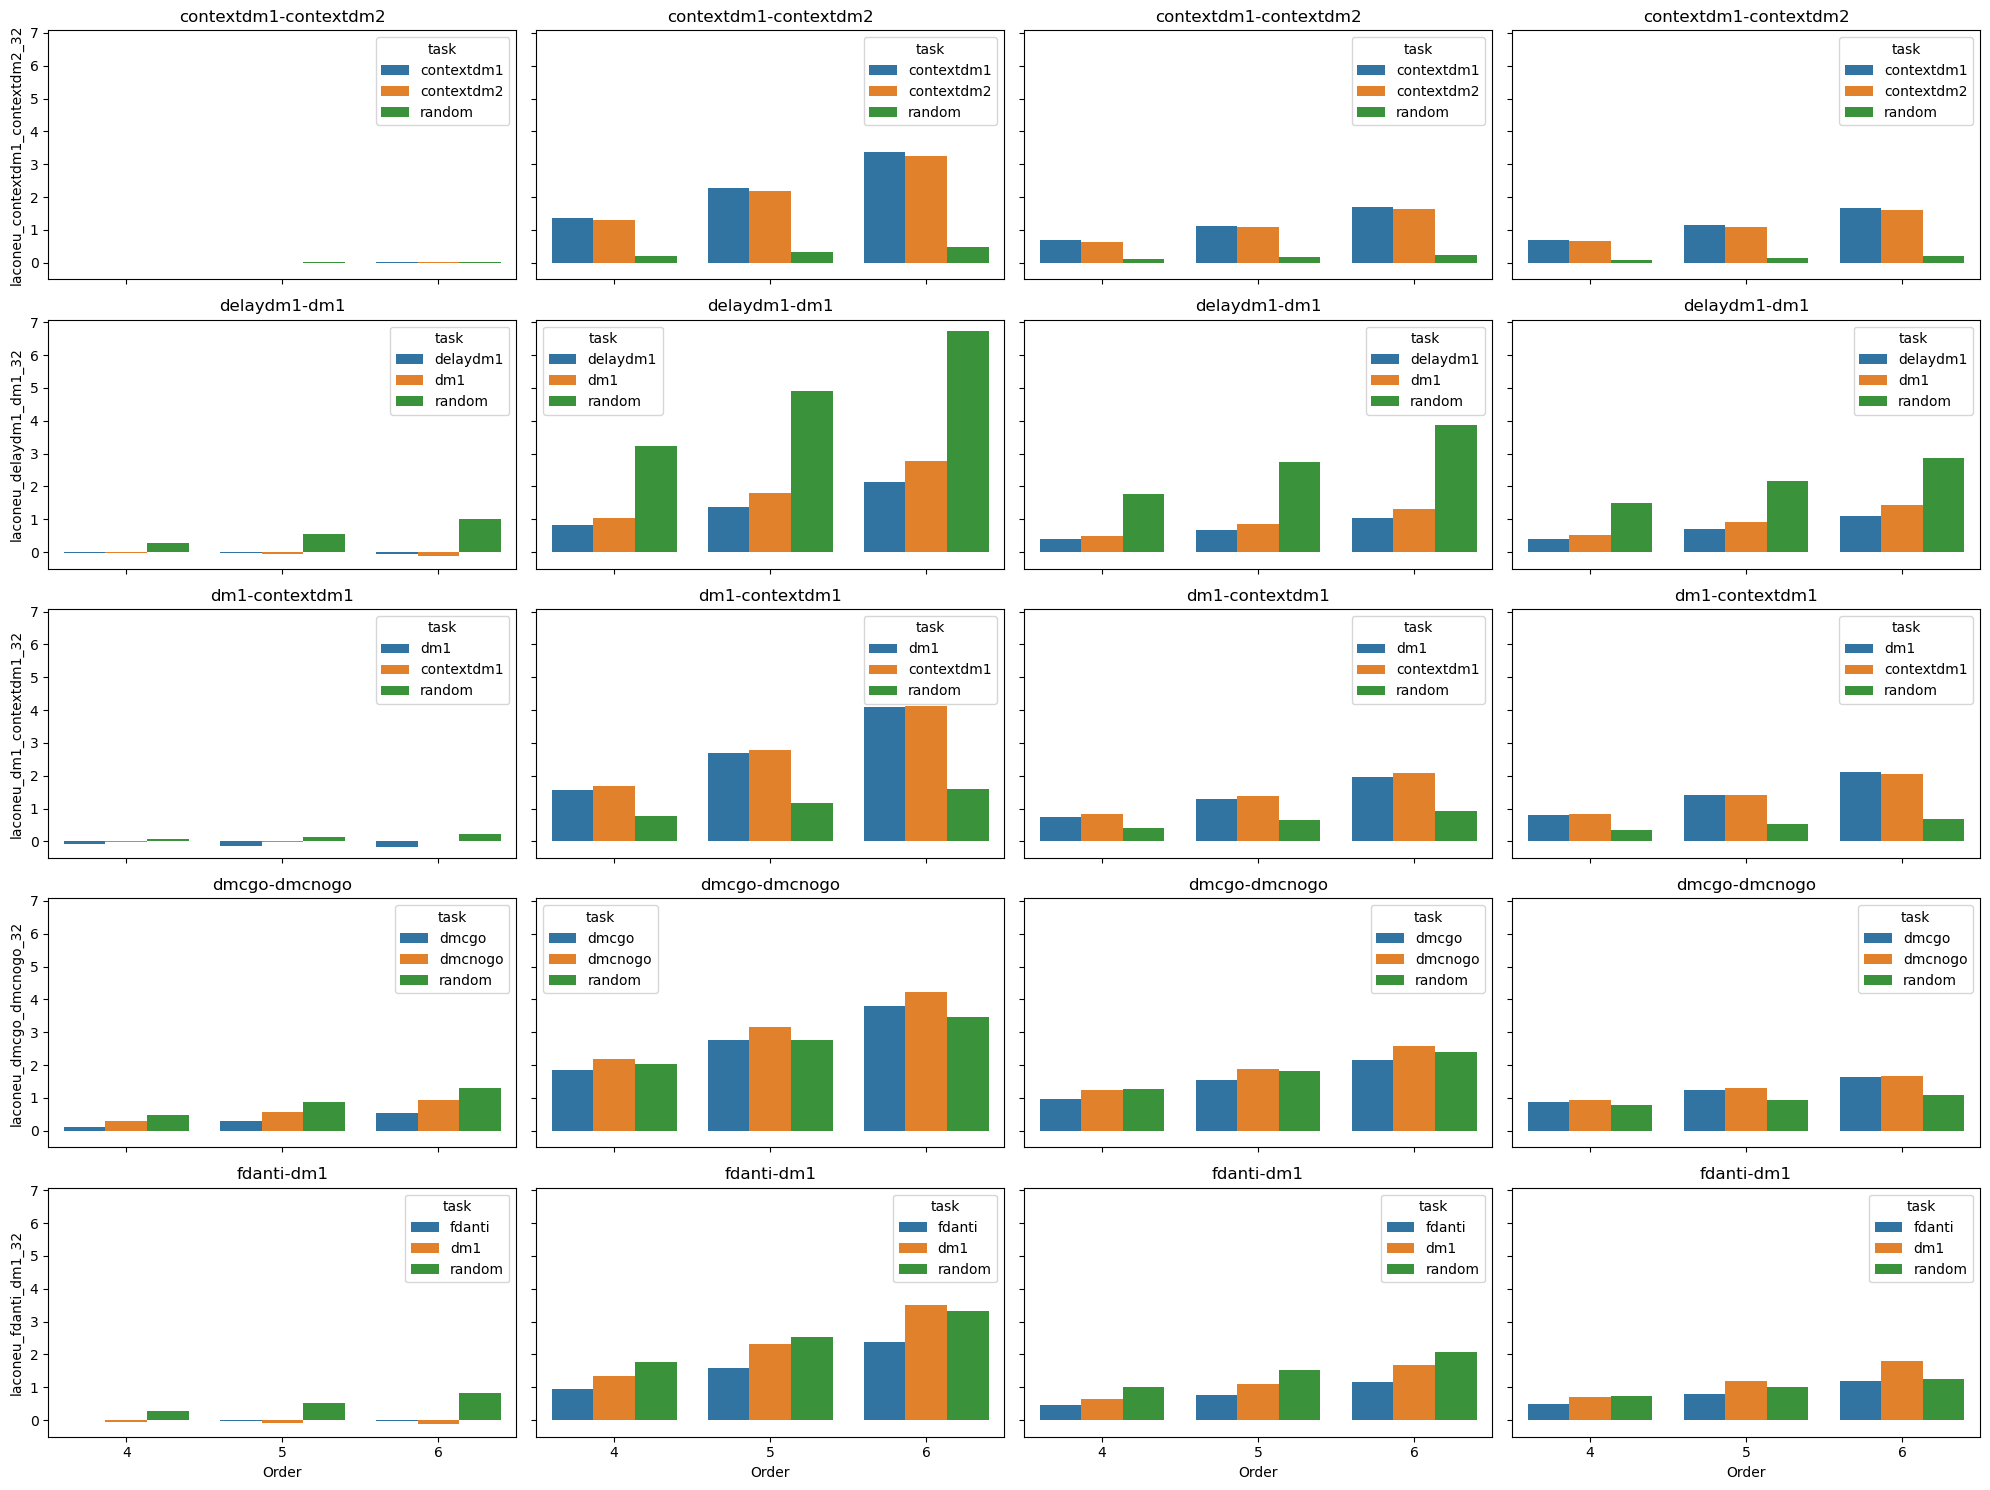

In [76]:
# make a subplot array of the different models with rows are models and columns are metrics
# the hue is the task and the x axis is the order
# the y axis is the metric
# the metric is o, s, tc, dtc
metrics = ['o', 's', 'tc', 'dtc']
fig, axes = plt.subplots(len(model_dirs), len(metrics), figsize=(20, 15), sharex=True, sharey=True)

for i, model in enumerate(model_dirs):
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        sns.barplot(data=concatenated_meanhoi[(concatenated_meanhoi['model'] == model) & (concatenated_meanhoi['order'] > 3)],
                    x='order', y=metric, hue='task', ax=ax)
        if i == 0:
            ax.set_title(metric)
        if j == 0:
            ax.set_ylabel(model)
        if i == len(model_dirs) - 1:
            ax.set_xlabel('Order')
        #title is the model name
        ax.set_title("-".join(model.split('_')[1:-1]))
plt.tight_layout()
plt.show()

In [1]:
plt.figure(figsize=(15, 5))
sns.barplot(data=concatenated_meanhoi[concatenated_meanhoi['task'] == 'random'], x='order', y='o', hue='model')


NameError: name 'plt' is not defined

In [16]:
from thoi.heuristics import simulated_annealing, greedy

#best_nplets, best_scores = greedy(hidden[:16].T, 3, 5, repeat=10)
#best_nplets, best_scores = simulated_annealing(hidden[:16].T, 5, repeat=10)


mean(o) = -0.7326119619928415 - ES: 26:   3%|▎         | 33/1000 [00:00<00:02, 323.19it/s]

mean(o) = -1.3971344035310094 - ES: 99:  89%|████████▉ | 892/1000 [00:02<00:00, 378.39it/s]2025-01-14 17:47:42,718 - INFO - Early stop reached
